# Oakland California Crime Data Analysis and Modeling

Programmer: Crystella Yufei Zheng (10/11/2020)

####Oakland ranks top 2 in the state of California in the past years according to https://www.roadsnacks.net/most-dangerous-cities-in-california/. Here we are going to study and analyze data during Covid-19 2020.

##0. Import Packages and Load Data

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [0]:
data_path = "dbfs:/FileStore/tables/CrimeWatch_Maps_Past_90_Days.csv"
#after upload to Databricks data; then copy the path of location from dbfs

In [0]:
import urllib.request
display(dbutils.fs.ls("dbfs:/FileStore/tables/CrimeWatch_Maps_Past_90_Days.csv"))

path,name,size
dbfs:/FileStore/tables/CrimeWatch_Maps_Past_90_Days.csv,CrimeWatch_Maps_Past_90_Days.csv,2182754


In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt = spark.read.format("csv").option("header", "true").load(data_path)
df_opt = df_opt.dropna() #drop all nulls
df_opt.limit(5).display()

CRIMETYPE,DATETIME,CASENUMBER,DESCRIPTION,POLICEBEAT,ADDRESS,CITY,STATE,Location
VANDALISM,07/26/2020 11:00:00 AM,20-914374,VANDALISM,08X,500 29TH ST,Oakland,CA,500 29TH ST
DOMESTIC VIOLENCE,08/21/2020 11:30:00 AM,20-041523,BATTERY:SPOUSE/EX SPOUSE/DATE/ETC,30X,80TH AV & PLYMOUTH ST,Oakland,CA,80TH AV & PLYMOUTH ST
BURG - AUTO,07/16/2020 01:20:00 PM,20-913439,BURGLARY-AUTO,77X,SKYLINE BLVD,Oakland,CA,SKYLINE BLVD
MISDEMEANOR ASSAULT,08/21/2020 07:16:00 PM,20-041573,SHOOT:INHAB DWELL/VEH/ETC,19X,2000 E 15TH ST,Oakland,CA,2000 E 15TH ST
PETTY THEFT,05/15/2020 10:00:00 PM,20-041214,THEFT,35X,90TH AV & THERMAL ST,Oakland,CA,90TH AV & THERMAL ST


In [0]:
# check the data types of all values and whether there are missing values
df_pd = df_opt.toPandas()
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13877 entries, 0 to 13876
Data columns (total 9 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 CRIMETYPE 13877 non-null object
 1 DATETIME 13877 non-null object
 2 CASENUMBER 13877 non-null object
 3 DESCRIPTION 13877 non-null object
 4 POLICEBEAT 13877 non-null object
 5 ADDRESS 13877 non-null object
 6 CITY 13877 non-null object
 7 STATE 13877 non-null object
 8 Location 13877 non-null object
dtypes: object(9)
memory usage: 975.9+ KB

##1. Data Preprocessing##

In [0]:
# Convert data type 
from pyspark.sql.functions import to_date
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import hour
from pyspark.sql.functions import year
from pyspark.sql.functions import month
from pyspark.sql.functions import date_format
from pyspark.sql.functions import col
from pyspark.sql.functions import concat
from pyspark.sql.functions import lit

In [0]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df_opt.withColumn("DATE", to_date("DATETIME", "MM/dd/yyyy")).withColumn("DATETIME", to_timestamp("DATETIME", "MM/dd/yyyy hh:mm:ss a")).withColumn("HOUR", hour("DATETIME")).withColumn("MINUTE", date_format("DATETIME", "m")).withColumn("YEAR", year("DATETIME")).withColumn("MONTH", month('DATETIME')).withColumn("DAY", date_format('DATETIME', 'd')).withColumn("DOW", date_format("DATETIME", "E"))
df.limit(5).display()
df.createOrReplaceTempView("crime_df")

CRIMETYPE,DATETIME,CASENUMBER,DESCRIPTION,POLICEBEAT,ADDRESS,CITY,STATE,Location,DATE,HOUR,MINUTE,YEAR,MONTH,DAY,DOW
VANDALISM,2020-07-26T11:00:00.000+0000,20-914374,VANDALISM,08X,500 29TH ST,Oakland,CA,500 29TH ST,2020-07-26,11,0,2020,7,26,Sun
DOMESTIC VIOLENCE,2020-08-21T11:30:00.000+0000,20-041523,BATTERY:SPOUSE/EX SPOUSE/DATE/ETC,30X,80TH AV & PLYMOUTH ST,Oakland,CA,80TH AV & PLYMOUTH ST,2020-08-21,11,30,2020,8,21,Fri
BURG - AUTO,2020-07-16T13:20:00.000+0000,20-913439,BURGLARY-AUTO,77X,SKYLINE BLVD,Oakland,CA,SKYLINE BLVD,2020-07-16,13,20,2020,7,16,Thu
MISDEMEANOR ASSAULT,2020-08-21T19:16:00.000+0000,20-041573,SHOOT:INHAB DWELL/VEH/ETC,19X,2000 E 15TH ST,Oakland,CA,2000 E 15TH ST,2020-08-21,19,16,2020,8,21,Fri
PETTY THEFT,2020-05-15T22:00:00.000+0000,20-041214,THEFT,35X,90TH AV & THERMAL ST,Oakland,CA,90TH AV & THERMAL ST,2020-05-15,22,0,2020,5,15,Fri


In [0]:
%sql
select count(distinct CRIMETYPE)
from crime_df

count(DISTINCT CRIMETYPE)
42


##2. OLAP##

####Q1 question (OLAP):
#####Write a Spark program that counts the number of crimes for different category

In [0]:
crimeCategory = df.groupBy('CRIMETYPE').count().orderBy('count', ascending=False)
crimeCategory_top20 = df.groupBy('CRIMETYPE').count().orderBy('count', ascending=False).limit(20)
crimeCategory.display()

CRIMETYPE,count
STOLEN VEHICLE,2024
MISDEMEANOR ASSAULT,1424
VANDALISM,1335
BURG - AUTO,1135
PETTY THEFT,934
DOMESTIC VIOLENCE,874
FELONY ASSAULT,732
ROBBERY,595
OTHER,594
GRAND THEFT,486


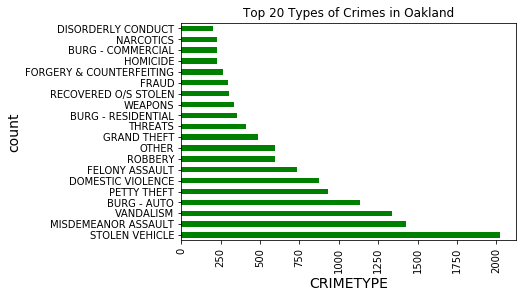

In [0]:
# visualize result
crime_pd_top20 = crimeCategory_top20.toPandas()
plt.figure()
ax = crime_pd_top20.plot(kind='barh', x='CRIMETYPE', y='count', color='green', legend=False, align='center')
ax.set_ylabel('count', fontsize = 14)
ax.set_xlabel('CRIMETYPE', fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.title('Top 20 Types of Crimes in Oakland')
display()

In [0]:
from pyspark.sql.functions import col

# convert “object" into "float"
crimeCategory = crimeCategory.withColumn('count', col('count').cast('float'))

# convert column into list
output = crimeCategory.select('count').collect()
cnts = [i[0] for i in output]

# to check which types criminals tend to do
high_rate = 0
mid_rate = 0
low_rate = 0
population_rate = 435224/100000

for cnt in cnts: 
  if cnt >= 1000:
    high_rate += (cnt/population_rate)
  elif cnt >= 100 and cnt < 999:
    mid_rate += (cnt/population_rate)
  elif cnt < 100:
    low_rate += (cnt/population_rate)
print(f'''High Rate:{round(high_rate, 4)}, 
Mid Rate: {round(mid_rate, 4)}, 
Low Rate: {round(low_rate, 4)}''')
print("Total Rate:" + str(round(high_rate+mid_rate+low_rate, 4)))

High Rate:1359.7596, 
Mid Rate: 1672.9316, 
Low Rate: 155.7819
Total Rate:3188.4731

#####Q1 Insight:
The population of Oakland, California 2020 is 435,224. During past 90 days, namely Covid-19, per 100,000 people, the high rate of criminal events remains 1359.76; the medium rate is 1672.93. The low rate is 155.78. Total rate is 3188.47. The medium rate occupies 52.47% of overall, which reminds us of California's Prop 47 causing to rise in shoplifting, thefts, criminal activity --- a law that changed certain low-level crimes from potential felonies to misdemeanors.

####Q2 question (OLAP):
#####Count the number of crimes for different streets, and visualize your results

In [0]:
# choose the criminal events that are over or equilvant to 20 times in the streets.
import pyspark.sql.functions as f
crimeStreet = df.groupBy('ADDRESS').count().orderBy('count', ascending = False).filter(f.col('count') >= 20)
display(crimeStreet)

ADDRESS,count
400 7TH ST,127
2600 73RD AV,53
3400 TELEGRAPH AV,38
00,38
3000 E 9TH ST,38
4000 ALAMEDA AV,33
500 INDEPENDENT RD,28
10700 MACARTHUR BLVD,27
3000 BROADWAY,27
1400 19TH AV,26


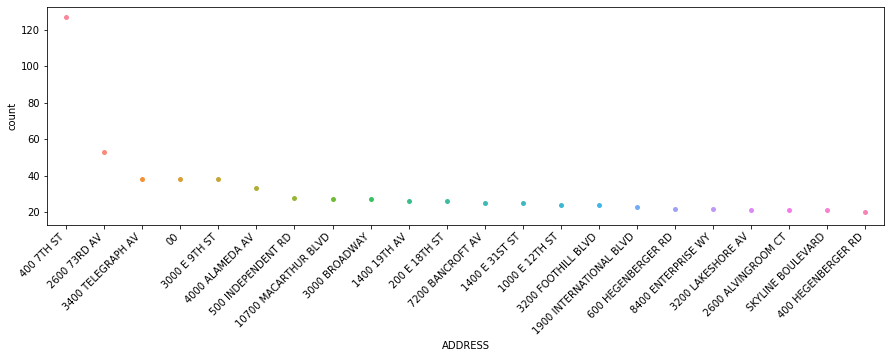

In [0]:
# visualize result
fig_dims = (15,4)
fig = plt.subplots(figsize = fig_dims)
oak_crime_add = crimeStreet.toPandas()
chart2 = sns.swarmplot(x = oak_crime_add['ADDRESS'], y = oak_crime_add['count'])
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
display()

#####Q2 Insight:
From the datasets, the top criminal site is 400 7th street in Oakland, followed by 2600 73rd av and 3400 Telegraph Av.

####Q3 question (OLAP):
#####Count the number of each "Sunday" during past 90 days (7/5/2020 - 10/5/2020) at top 3 criminal sites in Oakland CA. 
*Becase Oakland government did not provide latitude and longitude coordinates in open data, I replaced it by string of addresses instead.*

In [0]:
df_90days_top3 = spark.sql('select ADDRESS, count(*) as crime_counts from crime_df where DOW = "Sun" and (DATE between "2020-07-05" and "2020-10-05") group by 1 order by 2 desc limit 3')
display(df_90days_top3)

ADDRESS,crime_counts
400 7TH ST,16
300 SANTA CLARA AV,10
600 BROOKLYN AV,9


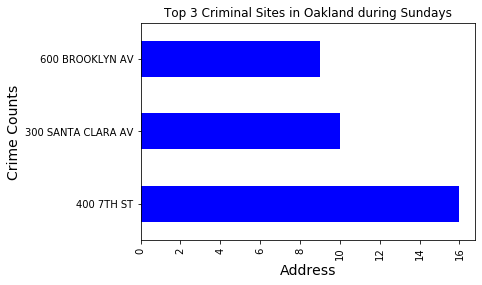

In [0]:
# visualize result
pd_90days_top3 = df_90days_top3.toPandas()
plt.figure()
ax = pd_90days_top3.plot(kind='barh', x='ADDRESS', y='crime_counts', color='blue', legend=False, align='center')
ax.set_ylabel('Crime Counts', fontsize = 14)
ax.set_xlabel('Address', fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.title('Top 3 Criminal Sites in Oakland during Sundays')
display()

####Q4 question (OLAP):
#####Analyze 2 comparisons from the crime data
1. Initial Breakout Stage (March, April, May) **vs.** Most Commonly Spreadying Season (July, August, September)
2. Non-Covid time **vs.** Covid time *(2015; Oakland gov provides latest open data of Crime Statistic 2015 only)*

In [0]:
# how many cases occurred in every month in 2020
crime_months = df.groupBy('YEAR', 'MONTH').count().orderBy('count', ascending = False).filter(f.col('YEAR') == 2020)
display(crime_months)
crime_months.createOrReplaceTempView('crime_mos_view')

YEAR,MONTH,count
2020,7,4513
2020,8,4451
2020,9,3784
2020,6,451
2020,10,231
2020,5,119
2020,4,66
2020,3,49
2020,2,28
2020,1,19


In [0]:
display(crime_months)

YEAR,MONTH,count
2020,7,4513
2020,8,4451
2020,9,3784
2020,6,451
2020,10,231
2020,5,119
2020,4,66
2020,3,49
2020,2,28
2020,1,19


In [0]:
diff_mos = spark.sql('with begin_mos as (select sum(count) as begin_mos_sum from crime_mos_view where MONTH in (3,4,5)), curr_mos as (select sum(count) as curr_mos_sum from crime_mos_view where MONTH in (7,8,9)) select curr_mos_sum - begin_mos_sum from begin_mos join curr_mos')
diff_mos.display()

(curr_mos_sum - begin_mos_sum)
12514


In [0]:
%sql
with begin_cat as (select CRIMETYPE, count(*) as begin_cnts from crime_df where MONTH IN (3,4,5) group by CRIMETYPE order by 2 desc),
     curr_cat as (select CRIMETYPE, count(*) as curr_cnts from crime_df where MONTH IN (7,8,9) group by CRIMETYPE order by 2 desc)
select a.CRIMETYPE, curr_cnts - begin_cnts
from begin_cat a join curr_cat b on a.CRIMETYPE=b.CRIMETYPE
order by 2 desc

CRIMETYPE,(curr_cnts - begin_cnts)
STOLEN VEHICLE,1855
MISDEMEANOR ASSAULT,1318
VANDALISM,1244
BURG - AUTO,1076
DOMESTIC VIOLENCE,827
PETTY THEFT,807
FELONY ASSAULT,672
ROBBERY,538
OTHER,527
GRAND THEFT,406


In [0]:
#download the crime 2015 report
data_path2 = "dbfs:/FileStore/tables/Crime_Data_2015.csv"

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis 2015") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt2 = spark.read.format("csv").option("header", "true").load(data_path2)
df_opt2 = df_opt2.dropna() #drop all nulls
df_opt2.limit(5).display()

CRIMETYPE,DATETIME,CASENUMBER,DESCRIPTION,POLICEBEAT,LOCATION,CITY,STATE
MISDEMEANOR ASSAULT,01/01/2015 12:00:00 AM,15-000098,DISTURB THE PEACE,35X,8400 MACARTHUR BLVD,Oakland,CA
DISORDERLY CONDUCT,01/01/2015 12:00:00 AM,15-000304,DISTURB THE PEACE,10Y,810 60TH ST,Oakland,CA
FORGERY & COUNTERFEITING,01/01/2015 12:00:00 AM,15-002086,OBT CREDIT/ETC:OTHER'S ID,30Y,6900 BANCROFT AV,Oakland,CA
OTHER,01/01/2015 12:00:00 AM,15-003479,FOUND PROPERTY,27X,5223 BELVEDERE ST,Oakland,CA
DISORDERLY CONDUCT,01/01/2015 12:00:00 AM,15-004084,DISTURB THE PEACE,30X,1929 73RD AV,Oakland,CA


In [0]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df_15 = df_opt2.withColumn("DATE", to_date("DATETIME", "MM/dd/yyyy")).withColumn("DATETIME", to_timestamp("DATETIME", "MM/dd/yyyy hh:mm:ss a")).withColumn("HOUR", hour("DATETIME")).withColumn("DOW", date_format("DATETIME", "E")).withColumn("MONTH", month('DATETIME')).withColumn("YEAR", year("DATETIME"))
df_15.display()
df_15.createOrReplaceTempView("crime_df_15")

CRIMETYPE,DATETIME,CASENUMBER,DESCRIPTION,POLICEBEAT,LOCATION,CITY,STATE,DATE,HOUR,DOW,MONTH,YEAR
MISDEMEANOR ASSAULT,2015-01-01T00:00:00.000+0000,15-000098,DISTURB THE PEACE,35X,8400 MACARTHUR BLVD,Oakland,CA,2015-01-01,0,Thu,1,2015
DISORDERLY CONDUCT,2015-01-01T00:00:00.000+0000,15-000304,DISTURB THE PEACE,10Y,810 60TH ST,Oakland,CA,2015-01-01,0,Thu,1,2015
FORGERY & COUNTERFEITING,2015-01-01T00:00:00.000+0000,15-002086,OBT CREDIT/ETC:OTHER'S ID,30Y,6900 BANCROFT AV,Oakland,CA,2015-01-01,0,Thu,1,2015
OTHER,2015-01-01T00:00:00.000+0000,15-003479,FOUND PROPERTY,27X,5223 BELVEDERE ST,Oakland,CA,2015-01-01,0,Thu,1,2015
DISORDERLY CONDUCT,2015-01-01T00:00:00.000+0000,15-004084,DISTURB THE PEACE,30X,1929 73RD AV,Oakland,CA,2015-01-01,0,Thu,1,2015
GRAND THEFT,2015-01-01T00:00:00.000+0000,15-012281,GRAND THEFT,12X,482 49TH ST,Oakland,CA,2015-01-01,0,Thu,1,2015
DISORDERLY CONDUCT,2015-01-01T00:00:00.000+0000,15-010757,DISTURB THE PEACE,29X,2610 62ND AV,Oakland,CA,2015-01-01,0,Thu,1,2015
FORGERY & COUNTERFEITING,2015-01-01T00:00:00.000+0000,15-014951,OBT CREDIT/ETC:OTHER'S ID,09X,76 LINDA AV,Oakland,CA,2015-01-01,0,Thu,1,2015
MISDEMEANOR ASSAULT,2015-01-01T00:00:00.000+0000,15-019236,BATTERY,23X,4010 ALAMEDA AV,Oakland,CA,2015-01-01,0,Thu,1,2015
FORGERY & COUNTERFEITING,2015-01-01T00:00:00.000+0000,15-030330,OBT CREDIT/ETC:OTHER'S ID,02Y,1658 12TH ST,Oakland,CA,2015-01-01,0,Thu,1,2015


In [0]:
diff_year = spark.sql('with 2015_cnts_tb as (select count(distinct CASENUMBER) as 2015_cnts from crime_df_15 where MONTH between 1 and 9), 2020_cnts_tb as (select sum(count) as 2020_cnts from crime_mos_view where MONTH between 1 and 9) select 2015_cnts - 2020_cnts from 2015_cnts_tb join 2020_cnts_tb')
diff_year.display()

(2015_cnts - 2020_cnts)
39105


#####Q4 Insight:
1. During the days when pandemic last, total number of criminal events in the begining (March, April, May) is 12,514 fewer than summer (July, August, September). 
    * It is not surprising to see many massive upsurge, such as misdemeanor assault, vandalism, felony assault, robbery, etc. 
    > From 22 May to 22 August, there were more than 10,600 BLM protest events in the United States according to Wikipedia (https://en.wikipedia.org/wiki/Black_Lives_Matter#2020).
    * Due to the governer's administrative order of lockdown, most skyrocketing cases are 'STOLEN VEHICLE', followed by 'MISDEMEANOR ASSAULT' and 'VANDALISM'. Besides that, 'Auto Burglary', 'DOMESTIC VIOLENCE' and 'PETTY THEFT' cannot be ignored.  

2. From the datasets of Crime 2015, criminal occurrences are far more than the pandemic period. Total number of criminal cases in 2015 are 39,105 more than in 2020. The lockdown order may cause duduced decresement.

####Q5 question (OLAP):
#####Analyze the number of crime w.r.t the hour from pandemic year and from non-Covid year. Then provide suggestion for residents or people who have to go there about the relatively safe time.

In [0]:
# merge 2 dataframes of hourly crime case counts
crime_hr_cnts_15 = spark.sql('select HOUR, count(*) as hourly_crime_cnts_15 from crime_df_15 group by HOUR order by HOUR')
crime_hr_cnts = spark.sql('select HOUR, count(*) as hourly_crime_cnts from crime_df group by HOUR order by HOUR')

output = crime_hr_cnts_15.join(crime_hr_cnts,['HOUR'],how='outer')
output.display()

HOUR,hourly_crime_cnts_15,hourly_crime_cnts
0,5758,864
1,2266,408
2,1772,356
3,1312,358
4,1001,325
5,954,244
6,1360,261
7,2277,374
8,3297,532
9,3526,573


In [0]:
output.display()

HOUR,hourly_crime_cnts_15,hourly_crime_cnts
0,5758,864
1,2266,408
2,1772,356
3,1312,358
4,1001,325
5,954,244
6,1360,261
7,2277,374
8,3297,532
9,3526,573


#####Q5 Insight:
* There are 5 peaks in the timeline graph - 12am, 12-2pm, 4-6pm, 8-9pm. 
* Residents and must-go visitors try to arrange your activities in the morning. 
* They are also requried to stay alert anytime even though it is at the relatively safe time.

####Q6 question (OLAP):
* Step 1: Find out the top-3 danger district
* Step 2: Find out the crime event w.r.t category and time (hour) from the result of Step 1
* Step 3: Give your advice to distribute the police based on your analysis results

In [0]:
top3_zone = df.groupBy('ADDRESS').count().orderBy('count', ascending = False).head(3)
top3_zone_lst = [top3_zone[i][0] for i in range(0,3)]
top3_zone_lst

Out[24]: ['400 7TH ST', '2600 73RD AV', '3400 TELEGRAPH AV']

In [0]:
display(top3_zone)

ADDRESS,count
400 7TH ST,127
2600 73RD AV,53
3400 TELEGRAPH AV,38


In [0]:
q6_s2_result = df.filter(df.ADDRESS.isin(top3_zone_lst)).groupby('CRIMETYPE','HOUR').count().orderBy('HOUR')
display(q6_s2_result)

CRIMETYPE,HOUR,count
BURG - COMMERCIAL,0,2
FORCIBLE RAPE,0,2
CHILD ABUSE,0,1
VANDALISM,0,1
PETTY THEFT,0,2
THREATS,0,1
FORGERY & COUNTERFEITING,0,2
BURG - RESIDENTIAL,0,1
OTHER SEX OFFENSES,0,2
OTHER,0,6


#####Q6 Advice:
- The top 3 danger streets are 400 7TH ST, 2600 73RD AV and  3400 TELEGRAPH AV.
- From Step 2,  the most dangerous hour in the top 3 danger streets is 2pm, followed by midnight 0am and noon 12pm. Police officers are better stay watch for onsite standby instead of patrol.

####Q7 question (OLAP):
#####For different category of crime, the percentage of weapon. Based on the output, give your hints to adjust the policy.

In [0]:
q3_res_1 = spark.sql("select HOUR, count(distinct CASENUMBER) as case_cnt from crime_df where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and YEAR == 2020 group by HOUR order by 2 desc limit 10")
q3_res_1.display()

HOUR,case_cnt
22,54
20,45
23,43
21,42
18,41
0,40
17,38
19,37
15,36
14,30


In [0]:
q3_res_2 = spark.sql("select DOW, count(distinct CASENUMBER) as case_cnt from crime_df where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and YEAR==2020 group by DOW order by 2 desc limit 10")
q3_res_2.display()

DOW,case_cnt
Sat,116
Mon,105
Fri,94
Tue,92
Wed,85
Sun,83
Thu,73


In [0]:
q3_res_3 = spark.sql("select count(distinct CASENUMBER) as case_cnt from crime_df where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and  YEAR == 2020")
q3_res_3.display()

case_cnt
648


In [0]:
%sql
with weapon_cnts as (select count(distinct CASENUMBER) as shoot_cnt from crime_df where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and  YEAR == 2020), total_cnts as (select count(distinct CASENUMBER) as case_cnt from crime_df where YEAR == 2020)
select shoot_cnt/case_cnt*100 as percentage
from weapon_cnts join total_cnts

percentage
5.608447290981478


#####Q7 Insight:
1. Usually, 8pm-10pm and Saturdays are the peak times of shoot crime.
2. It is unbelievable to see the percentage of weapon-related criminal events occupies only 5.6%, which seems that gun use is under control in such an unsafety city.
3. Police should continue to keep watch for that even thought the percentage is not that high.

####Q8 question (optional):
#####Analyze the enviornment, housing, races and living status in 2016

* How many parks and recreation facilities in Oakland?

In [0]:
data_path3 = 'dbfs:/FileStore/tables/Parks_and_Recreation_Facilities.csv'

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("parks and facilities") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_fa = spark.read.format("csv").option("header", "true").load(data_path3)
df_fa = df_fa.dropna()
df_fa.limit(10).display()

Parks and Recreation Facilities,Facility Type,Phone Number,URL,Location 1
Peralta Hacienda Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,2500 34th Avenue
"Arroyo Viejo, Lucky A's",Tennis Court,(510) 444-5663,http://www2.oaklandnet.com/Government/o/opr/s/Tennis/index.htm,7921 Olive Street
San Antonio Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,1701 E 19th Street
Verdese Carter Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,9600 Sunnyside Street
Lake Merritt Sail Boat House,Rental Facility,(510) 238-3187,http://www2.oaklandnet.com/Government/o/opr/s/rental/OAK029374,568 Bellevue Avenue
Vantage Point Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,1198 13th Avenue
Arroyo Viejo Recreation Center,ADA Inclusion Center,(510) 615-5980,http://www2.oaklandnet.com/Government/o/opr/s/ADAInclusionCenter/index.htm,7701 Krause Avenue
Arroyo Viejo Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,7701 Krause Avenue
Mosswood Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,3612 Webster Street
Union Point Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/Parks/index.htm,2311 Embarcadero


In [0]:
df_fac = df_fa["Parks and Recreation Facilities","Facility Type","Location 1"]
df_fac = df_fac.withColumnRenamed("Facility Type", "FacilityType").withColumnRenamed("Parks and Recreation Facilities", "ParkandRec").withColumnRenamed("Location 1", "Location")
df_fac.limit(10).display()
df_fac.createOrReplaceTempView("fac_view")

ParkandRec,FacilityType,Location
Peralta Hacienda Park,Park,2500 34th Avenue
"Arroyo Viejo, Lucky A's",Tennis Court,7921 Olive Street
San Antonio Park,Park,1701 E 19th Street
Verdese Carter Park,Park,9600 Sunnyside Street
Lake Merritt Sail Boat House,Rental Facility,568 Bellevue Avenue
Vantage Point Park,Park,1198 13th Avenue
Arroyo Viejo Recreation Center,ADA Inclusion Center,7701 Krause Avenue
Arroyo Viejo Park,Park,7701 Krause Avenue
Mosswood Park,Park,3612 Webster Street
Union Point Park,Park,2311 Embarcadero


In [0]:
fac_count = df_fac.groupby("FacilityType").count().orderBy('count', ascending = False)
display(fac_count)

FacilityType,count
Park,127
Athletic Field,30
Recreation Center,22
Tennis Court,14
Rental Facility,8
Pools,6
Community Gardens,6
Cultural Arts,3
Golf Course,3
Discovery Center,2


In [0]:
display(fac_count)

FacilityType,count
Park,127
Athletic Field,30
Recreation Center,22
Tennis Court,14
Rental Facility,8
Pools,6
Community Gardens,6
Cultural Arts,3
Golf Course,3
Discovery Center,2


In [0]:
loc_count = df_fac.groupby("Location").count().orderBy('count', ascending = False)
display(loc_count)

Location,count
3612 Webster Street,4
6300 Moraga Avenue,4
3131 Union Street,3
3860 Hanly Road,3
666 Bellevue Avenue,3
7701 Krause Avenue,3
10315 E Street,2
247 Marlow Drive,2
3711 Suter Street,2
1969 Park Boulevard,2


In [0]:
df_fac.groupby("Location").count().orderBy('count', ascending = False).filter(f.col('count') > 1).display()

Location,count
6300 Moraga Avenue,4
3612 Webster Street,4
666 Bellevue Avenue,3
7701 Krause Avenue,3
3131 Union Street,3
3860 Hanly Road,3
9175 Edes Avenue,2
9161 Edes Avenue,2
1969 Park Boulevard,2
5000 Redwood Road,2


* What are the percentages of races who own house(s)?

In [0]:
data_path4 = "dbfs:/FileStore/tables/homeownership.csv"

spark = SparkSession \
    .builder \
    .appName("homeownership") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_hou = spark.read.format("csv").option("header", "true").load(data_path4)
df_hou = df_hou.dropna()
display(df_hou.take(5))

Race/Ethnicity,Percent,Year
African American,74.0788446526151400,2016
Asian,48.088825891802500,2016
Latino,68.9654239489205100,2016
White,43.5859756827656800,2016
Other,70.105820105820100,2016


* What are the percentages of races who rent house(s)?

In [0]:
file_location = "/FileStore/tables/rent_burden.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_rent = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .option("sep", delimiter) \
  .load(file_location)

display(df_rent.take(5))

Race/Ethnicity,Percent,Year
African American,58.4192050730381600,2016
Asian,49.157145053030700,2016
Latino,52.7104722792607800,2016
White,34.896008702634100,2016
Other,48.66371120962635400,2016


* What are rates of races who are homeless?

In [0]:
#The rates of races who are homeless
file_location = "/FileStore/tables/homelessness.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_homeless = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", "true") \
  .option("sep", delimiter) \
  .load(file_location)

display(df_homeless)

Race/Ehnicity,Rate,Year
African American,1796.95829863803,2016
Asian,43.02767734696422,2016
White,268.64945511157237,2016
Latino,329.2564837649483,2016
Non-Latino,774.1976780419056,2016


#####Q8 Insight:
- There are still lots of parks and leisure facilities for residents to choose even though criminal events happen almost everyday. Based on the previous analysis of perilous streets and boom hours, residents are still able to chill out in those facilities. Not only that government strived as much as possible on urban planning.
- For races who rent or own houses, all races almost enjoy the relatively same shares except Asians. Asians who rent houses are more than themselves who own houses, of which this finding is bizarre. Asians usually prefer taking possession of houses than renting. Here's my guess that the rental fee is cheaper than other areas so Asians just temporarily rent houses until their saving is enough to afford a house in their dream places and then they will move out of Oakland.
- With respect to homelessness, African American is majority.

#3. Modeling

#####The Steps of this Modeling:
1. Apply StringIndexer and One Hot Encoding on Categorical columns, then assemble all those converted Categorical columns and numeric columns by VectorAssembler; in the end, pipeline all those methods together.
2. Due to a great many features, we'd better theck whether they are highly correlated.
3. Dimensionality reduction by PCA
4. Apply K-Means clustering for unsupervised learning and evaluate by ClusteringEvaluator
5. Choose the best score according to Silhouette method for the final K
6. Obtain the prediction and the centers of all clusters throught the K-means clustering model

In [0]:
# convert Numberic Columns into Float
cols = ['HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY']
for col_name in cols:
    df = df.withColumn(col_name, col(col_name).cast('float'))
df.printSchema()

root
-- CRIMETYPE: string (nullable = true)
-- DATETIME: timestamp (nullable = true)
-- CASENUMBER: string (nullable = true)
-- DESCRIPTION: string (nullable = true)
-- POLICEBEAT: string (nullable = true)
-- ADDRESS: string (nullable = true)
-- CITY: string (nullable = true)
-- STATE: string (nullable = true)
-- Location: string (nullable = true)
-- DATE: date (nullable = true)
-- HOUR: float (nullable = true)
-- MINUTE: float (nullable = true)
-- YEAR: float (nullable = true)
-- MONTH: float (nullable = true)
-- DAY: float (nullable = true)
-- DOW: string (nullable = true)

####3.1 Feature Engineering

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ["CRIMETYPE", "ADDRESS", "DOW"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

# Transform all features into a vector using VectorAssembler
numericCols = ["HOUR", "MINUTE", "YEAR", "MONTH", "DAY"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
assembled_df = pipelineModel.transform(df)
assembled_df.show(2)

+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+
 CRIMETYPE| DATETIME|CASENUMBER| DESCRIPTION|POLICEBEAT| ADDRESS| CITY|STATE| Location| DATE|HOUR|MINUTE| YEAR|MONTH| DAY|DOW|CRIMETYPEIndex|CRIMETYPEclassVec|ADDRESSIndex| ADDRESSclassVec|DOWIndex| DOWclassVec| features|
+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+
 VANDALISM|2020-07-26 11:00:00| 20-914374| VANDALISM| 08X| 500 29TH ST|Oakland| CA| 500 29TH ST
2020-07-26|11.0| 0.0|2020.0| 7.0|26.0|Sun| 2.0| (41,[2],[1.0])| 439.0| (5491,[439],[1.0])| 5.0|(6,[5],[1.0])|(5543,[2,480,5537...|
DOMESTIC VIOLENCE|2020-08-21 11:30:00| 20-041523|BATTERY:SPOUSE/EX...| 30X|80TH AV & PLYMOUT...|Oakland| CA|80TH AV & PLYMOUT...|2020-08-21|11.0| 30.0|2020.0| 8.0|21.0|Fri| 5.0| (41,[5],[1.0])| 5001.0|(5491,[5001],[1.0])| 0.0|(6,[0],[1.0])|(5543,[5,5042,553...|
+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+
only showing top 2 rows

In [0]:
# check whether features are highly correlated
from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(assembled_df, "features", "pearson").collect()[0][0]
print("Pearson correlation matrix:")
print(str(pearsonCorr).replace('nan', 'NaN'))

Pearson correlation matrix:
DenseMatrix([[ 1. , -0.13973626, -0.13481814, ..., 0.01861511,
 -0.02748582, 0.0116143 ],
 [-0.13973626, 1. , -0.11032533, ..., 0.01786748,
 0.08103482, 0.00784584],
 [-0.13481814, -0.11032533, 1. , ..., 0.00964476,
 -0.02314903, 0.01063267],
 ...,
 [ 0.01861511, 0.01786748, 0.00964476, ..., 1. ,
 0.09075887, 0.05595235],
 [-0.02748582, 0.08103482, -0.02314903, ..., 0.09075887,
 1. , -0.11234869],
 [ 0.0116143 , 0.00784584, 0.01063267, ..., 0.05595235,
 -0.11234869, 1. ]])

In [0]:
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(assembled_df)
pca_df = pca_model.transform(assembled_df)
pca_df.show(3)

+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+--------------------+
 CRIMETYPE| DATETIME|CASENUMBER| DESCRIPTION|POLICEBEAT| ADDRESS| CITY|STATE| Location| DATE|HOUR|MINUTE| YEAR|MONTH| DAY|DOW|CRIMETYPEIndex|CRIMETYPEclassVec|ADDRESSIndex| ADDRESSclassVec|DOWIndex| DOWclassVec| features| pcaFeatures|
+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+--------------------+
 VANDALISM|2020-07-26 11:00:00| 20-914374| VANDALISM| 08X| 500 29TH ST|Oakland| CA| 500 29TH ST
2020-07-26|11.0| 0.0|2020.0| 7.0|26.0|Sun| 2.0| (41,[2],[1.0])| 439.0| (5491,[439],[1.0])| 5.0|(6,[5],[1.0])|(5543,[2,480,5537...|[1.66729325328638...|
DOMESTIC VIOLENCE|2020-08-21 11:30:00| 20-041523|BATTERY:SPOUSE/EX...| 30X|80TH AV & PLYMOUT...|Oakland| CA|80TH AV & PLYMOUT...|2020-08-21|11.0| 30.0|2020.0| 8.0|21.0|Fri| 5.0| (41,[5],[1.0])| 5001.0|(5491,[5001],[1.0])| 0.0|(6,[0],[1.0])|(5543,[5,5042,553...|[31.6305314250590...|
 BURG - AUTO|2020-07-16 13:20:00| 20-913439| BURGLARY-AUTO| 77X| SKYLINE BLVD|Oakland| CA| SKYLINE BLVD
2020-07-16|13.0| 20.0|2020.0| 7.0|16.0|Thu| 3.0| (41,[3],[1.0])| 479.0| (5491,[479],[1.0])| 6.0| (6,[],[])|(5543,[3,520,5538...|[21.6221428696872...|
+-----------------+-------------------+----------+--------------------+----------+--------------------+-------+-----+--------------------+----------+----+------+------+-----+----+---+--------------+-----------------+------------+-------------------+--------+-------------+--------------------+--------------------+
only showing top 3 rows

####3.2 Model Building and Evaluation

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='pcaFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='pcaFeatures', k=i)
    KMeans_fit=KMeans_algo.fit(pca_df)
    output=KMeans_fit.transform(pca_df)
    
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette with squared euclidean distance = " + str(score))

Silhouette with squared euclidean distance = 0.6849337738561834
Silhouette with squared euclidean distance = 0.5473490829256872
Silhouette with squared euclidean distance = 0.48402032409330287
Silhouette with squared euclidean distance = 0.5070697790753309
Silhouette with squared euclidean distance = 0.4619057461455986
Silhouette with squared euclidean distance = 0.4598906884732294
Silhouette with squared euclidean distance = 0.4553301599505823
Silhouette with squared euclidean distance = 0.4392148632525976

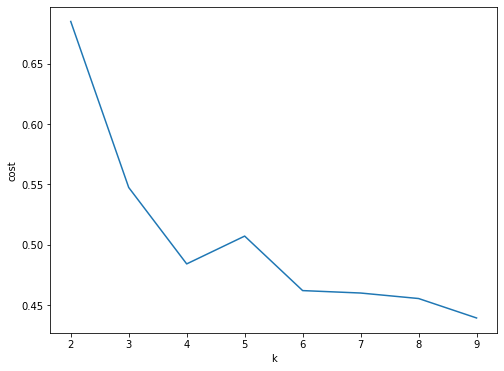

In [0]:
# visualize the silhouette scores in a plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

#####Graph and Score Insight:
I prefer K=5 where a local maxima of Silhouette Score is observed. Therefore, the final model is executed with k=5.

In [0]:
KMeans_algo=KMeans(featuresCol='pcaFeatures', k=5)
KMeans_fit=KMeans_algo.fit(pca_df)
output=KMeans_fit.transform(pca_df)
ctr = []
centers = KMeans_fit.clusterCenters()
print("Cluster Centers: ")
for center in centers:
      ctr.append(center)
      print(center)

Cluster Centers: 
[49.22668197 16.21101304 18.09811528]
[ 3.41555692 23.98068475 17.70932543]
[27.67204946 31.74401564 17.59416828]
[49.13036317 31.39882679 16.83632049]
[26.83025832 16.10201013 18.12558758]

####3.3 Visualization

In [0]:
# merge multiple dataframes into one and plot them in 3D
pca_pd = pca_df.toPandas()
output_pd = output.toPandas()
graph_pd = assembled_df.select("CRIMETYPEIndex", "DOWIndex", "HOUR", "features").toPandas()
new_graph_pd = graph_pd.merge(pca_pd, on='features').merge(output_pd,on='pcaFeatures')
new_graph_pd.head(3)

,CRIMETYPEIndex_x,DOWIndex_x,HOUR_x,features_x,CRIMETYPE_x,DATETIME_x,CASENUMBER_x,DESCRIPTION_x,POLICEBEAT_x,ADDRESS_x,CITY_x,STATE_x,Location_x,DATE_x,HOUR_y,MINUTE_x,YEAR_x,MONTH_x,DAY_x,DOW_x,CRIMETYPEIndex_y,CRIMETYPEclassVec_x,ADDRESSIndex_x,ADDRESSclassVec_x,DOWIndex_y,DOWclassVec_x,pcaFeatures,CRIMETYPE_y,DATETIME_y,CASENUMBER_y,DESCRIPTION_y,POLICEBEAT_y,ADDRESS_y,CITY_y,STATE_y,Location_y,DATE_y,HOUR,MINUTE_y,YEAR_y,MONTH_y,DAY_y,DOW_y,CRIMETYPEIndex,CRIMETYPEclassVec_y,ADDRESSIndex_y,ADDRESSclassVec_y,DOWIndex,DOWclassVec_y,features_y,prediction
0,2.0,5.0,11.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",VANDALISM,2020-07-26 11:00:00,20-914374,VANDALISM,08X,500 29TH ST,Oakland,CA,500 29TH ST\n,2020-07-26,11.0,0.0,2020.0,7.0,26.0,Sun,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",439.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","[1.6672932532863833, 34.188614991956044, 15.93...",VANDALISM,2020-07-26 11:00:00,20-914374,VANDALISM,08X,500 29TH ST,Oakland,CA,500 29TH ST\n,2020-07-26,11.0,0.0,2020.0,7.0,26.0,Sun,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",439.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,5.0,0.0,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",DOMESTIC VIOLENCE,2020-08-21 11:30:00,20-041523,BATTERY:SPOUSE/EX SPOUSE/DATE/ETC,30X,80TH AV & PLYMOUTH ST,Oakland,CA,80TH AV & PLYMOUTH ST\n,2020-08-21,11.0,30.0,2020.0,8.0,21.0,Fri,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5001.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[31.630531425059093, 28.94392016144611, 15.660...",DOMESTIC VIOLENCE,2020-08-21 11:30:00,20-041523,BATTERY:SPOUSE/EX SPOUSE/DATE/ETC,30X,80TH AV & PLYMOUTH ST,Oakland,CA,80TH AV & PLYMOUTH ST\n,2020-08-21,11.0,30.0,2020.0,8.0,21.0,Fri,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5001.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",2
2,3.0,6.0,13.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",BURG - AUTO,2020-07-16 13:20:00,20-913439,BURGLARY-AUTO,77X,SKYLINE BLVD,Oakland,CA,SKYLINE BLVD\n,2020-07-16,13.0,20.0,2020.0,7.0,16.0,Thu,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",479.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[21.62214286968729, 24.11156950515639, 17.9903...",BURG - AUTO,2020-07-16 13:20:00,20-913439,BURGLARY-AUTO,77X,SKYLINE BLVD,Oakland,CA,SKYLINE BLVD\n,2020-07-16,13.0,20.0,2020.0,7.0,16.0,Thu,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",479.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


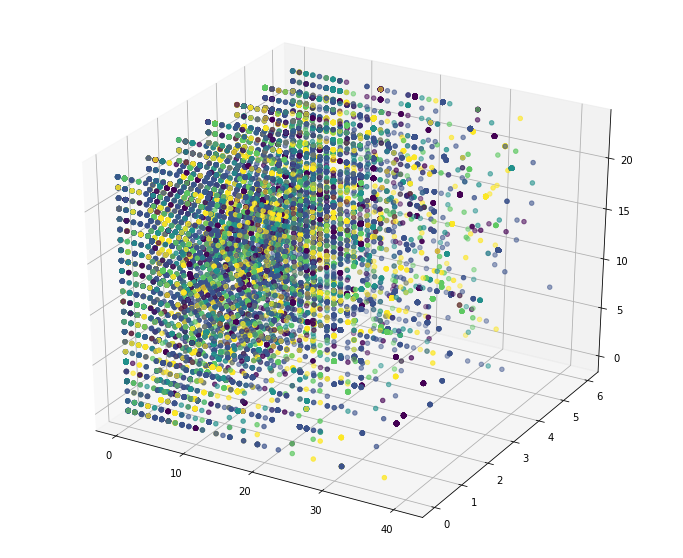

In [0]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(new_graph_pd.CRIMETYPEIndex, new_graph_pd.DOWIndex, new_graph_pd.HOUR, c=new_graph_pd.prediction, cmap='viridis', linewidth=1)
ax.scatter()

ax.set_xlabel('CrimeType')
ax.set_ylabel('Day')
ax.set_zlabel('Hour')
plt.show()

####3.4 Analysis

In [0]:
output.select('prediction').groupBy('prediction').count().orderBy('prediction').display()

prediction,count
0,1577
1,5874
2,2442
3,1570
4,2414


In [0]:
watch_cluster = output.filter(f.col("prediction") == 1)
watch_cluster.display()
watch_cluster.createOrReplaceTempView('watch_view')

CRIMETYPE,DATETIME,CASENUMBER,DESCRIPTION,POLICEBEAT,ADDRESS,CITY,STATE,Location,DATE,HOUR,MINUTE,YEAR,MONTH,DAY,DOW,CRIMETYPEIndex,CRIMETYPEclassVec,ADDRESSIndex,ADDRESSclassVec,DOWIndex,DOWclassVec,features,pcaFeatures,prediction
VANDALISM,2020-07-26T11:00:00.000+0000,20-914374,VANDALISM,08X,500 29TH ST,Oakland,CA,500 29TH ST,2020-07-26,11.0,0.0,2020.0,7.0,26.0,Sun,2.0,"List(0, 41, List(2), List(1.0))",439.0,"List(0, 5491, List(439), List(1.0))",5.0,"List(0, 6, List(5), List(1.0))","List(0, 5543, List(2, 480, 5537, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 11.0, 2020.0, 7.0, 26.0))","List(1, 3, List(), List(1.6672932532863833, 34.188614991956044, 15.935669325950382))",1
PETTY THEFT,2020-05-15T22:00:00.000+0000,20-041214,THEFT,35X,90TH AV & THERMAL ST,Oakland,CA,90TH AV & THERMAL ST,2020-05-15,22.0,0.0,2020.0,5.0,15.0,Fri,4.0,"List(0, 41, List(4), List(1.0))",5147.0,"List(0, 5491, List(5147), List(1.0))",0.0,"List(0, 6, List(0), List(1.0))","List(0, 5543, List(4, 5188, 5532, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 22.0, 2020.0, 5.0, 15.0))","List(1, 3, List(), List(1.7494028850205328, 23.62216358708872, 27.32466608646186))",1
PETTY THEFT,2020-08-19T18:00:00.000+0000,20-041509,THEFT,04X,1500 MADISON ST,Oakland,CA,1500 MADISON ST,2020-08-19,18.0,0.0,2020.0,8.0,19.0,Wed,4.0,"List(0, 41, List(4), List(1.0))",523.0,"List(0, 5491, List(523), List(1.0))",1.0,"List(0, 6, List(1), List(1.0))","List(0, 5543, List(4, 564, 5533, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 18.0, 2020.0, 8.0, 19.0))","List(1, 3, List(), List(1.7285282395849857, 27.427880270585355, 23.18460495834559))",1
STOLEN VEHICLE,2020-08-09T17:00:00.000+0000,20-039610,VEHICLE THEFT - AUTO,35X,2200 98TH AV,Oakland,CA,2200 98TH AV,2020-08-09,17.0,0.0,2020.0,8.0,9.0,Sun,0.0,"List(0, 41, List(0), List(1.0))",820.0,"List(0, 5491, List(820), List(1.0))",5.0,"List(0, 6, List(5), List(1.0))","List(0, 5543, List(0, 861, 5537, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 17.0, 2020.0, 8.0, 9.0))","List(1, 3, List(), List(1.6388277396931974, 17.40328075411377, 22.54854675561947))",1
STOLEN VEHICLE,2020-07-28T14:00:00.000+0000,20-037298,VEHICLE THEFT - AUTO,02Y,1300 WOOD ST,Oakland,CA,1300 WOOD ST,2020-07-28,14.0,0.0,2020.0,7.0,28.0,Tue,0.0,"List(0, 41, List(0), List(1.0))",1738.0,"List(0, 5491, List(1738), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))","List(0, 5543, List(0, 1779, 5536, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 14.0, 2020.0, 7.0, 28.0))","List(1, 3, List(), List(1.7268806637834817, 36.29353758402729, 18.867416750891916))",1
VANDALISM,2020-09-01T18:00:00.000+0000,20-043535,BATTERY,77X,SKYLINE BLVD,Oakland,CA,SKYLINE BLVD,2020-09-01,18.0,0.0,2020.0,9.0,1.0,Tue,2.0,"List(0, 41, List(2), List(1.0))",479.0,"List(0, 5491, List(479), List(1.0))",4.0,"List(0, 6, List(4), List(1.0))","List(0, 5543, List(2, 520, 5536, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 18.0, 2020.0, 9.0, 1.0))","List(1, 3, List(), List(1.6024176671726031, 9.428841377573395, 23.835911225488676))",1
DOMESTIC VIOLENCE,2020-08-21T08:00:00.000+0000,20-041549,INFLICT CORPORAL INJURY ON SPOUSE/COHABITANT,07X,3200 ADELINE ST,Oakland,CA,3200 ADELINE ST,2020-08-21,8.0,0.0,2020.0,8.0,21.0,Fri,5.0,"List(0, 41, List(5), List(1.0))",39.0,"List(0, 5491, List(39), List(1.0))",0.0,"List(0, 6, List(0), List(1.0))","List(0, 5543, List(5, 80, 5532, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 8.0, 2020.0, 8.0, 21.0))","List(1, 3, List(), List(1.5887173261667353, 29.06965160323109, 13.121857296830964))",1
DOMESTIC VIOLENCE,2020-08-21T08:00:00.000+0000,20-041549,BATTERY,07X,3200 ADELINE ST,Oakland,CA,3200 ADELINE ST,2020-08-21,8.0,0.0,2020.0,8.0,21.0,Fri,5.0,"List(0, 41, List(5), List(1.0))",39.0,"List(0, 5491, List(39), List(1.0))",0.0,"List(0, 6, List(0), List(1.0))","List(0, 5543, List(5, 80, 5532, 5538, 5540, 5541, 5542), List(1.0, 1.0, 1.0, 8.0, 2020.0, 8.0, 21.0))","List(1, 3, List(), List(1.5887173261667353, 29.06965160323109, 13.121857296830964))",1
DOMESTIC VIOLENCE,2020-08-21T08:00:00.000+0000

In [0]:
%sql
select CRIMETYPE, count(*) AS type_cnt
from watch_view
group by 1
order by 2 desc
limit 5

CRIMETYPE,type_cnt
STOLEN VEHICLE,1160
VANDALISM,626
PETTY THEFT,541
BURG - AUTO,532
MISDEMEANOR ASSAULT,430


In [0]:
%sql
select HOUR, count(*) as hour_cnt
from watch_view
group by HOUR
order by 2 desc
limit 5

HOUR,hour_cnt
0.0,551
12.0,454
18.0,332
22.0,327
17.0,308


In [0]:
%sql
select DOW, count(*) as day_cnt
from watch_view
group by 1
order by 2 desc

DOW,day_cnt
Sat,894
Wed,891
Fri,883
Sun,831
Mon,807
Thu,796
Tue,772


In [0]:
%sql
with cluster1_tb as (select count(distinct CASENUMBER) as shoot_cnt 
                     from watch_view 
                     where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and  YEAR == 2020), 
     total_cnts as (select count(distinct CASENUMBER) as case_cnt 
                     from crime_df 
                     where (DESCRIPTION like '%WEAPON%' or DESCRIPTION like '%SHOOT%') and  YEAR == 2020)
select shoot_cnt/case_cnt*100 as percentage
from cluster1_tb join total_cnts

percentage
32.71604938271605


#####3.4 Insight:
- As we can see, Cluster 1 has the most cases among all clusters. After zooming in all data that belong to the Cluster 1, we can see something in common that criminals will act on STOLEN CAR, VANDALISM, PETTY THEFT at midnight during weekends and Wednesdays. 
- Whenever falling on these factors during patrolling, police should stay sensitively alerted. Tourists and residents should take away valuable belongings whenever they leave the car, keep an eye on bags or wallets and make notice around when they walk outside.
- Gun shot in Cluster 1 occupies 32.72% among all clusters, which is higher than average. 
- All factors in Cluster 1 should be analyzed as detailed as possible and concentrated to monitor and solve; then take turns to the next most cluster.

#4. Conclustion

#####Business Insight:
1. Oakland CA acutally is a perfect place for living as it is close to San Francisco downtown. Especially, housing in San Francisco has been skyrocketing during recent years. Housing in Oakland is definitely lower than in San Francisco and even other bay areas. People who cannot afford housing may consider this substitute. Hence, the factors of crime, governmental-constructed leisure facilities, races of residents, etc need to be analyzed and elaborated for those real estate companies to figure out the potential customers, market value and safety issues.

2. It's not only pandemic but also previous years that Oakland keeps a high trend of ciminal occurences. Perhaps, it causes low market values for lands. If there are other options to develop, Oakland should be the last option. If the group has to choose Oakland CA, location is the vitalest and keep them furthest from downtown.  

#####Method:
1. Make use of spark SQL and pyspark for data cleaning, then data parsing and exploratory and comparison tables building by pyspark Dataframe, pandas and spark SQL.
2. Take advantage of built-in graphing tools to visualize most of dataframes; others are applied with pythong Matplotlib package.
3. For modeling and evaluation, pyspark MLlib packages have been applied, such as PCA, correlation, k-means clustering, clustering evaluator, string indexer, one hot encoder, etc.